In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trainnn/train_data1.json
/kaggle/input/validation/val_data1.json


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import json
import numpy as np
import re
import string
import nltk
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
with open('/kaggle/input/trainnn/train_data1.json', 'r') as file: # Replace this path with the dataset path in your local machine
    data = json.load(file)

In [4]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
# Process JSON data
source_sentences_train = []
target_sentences_train = []

source_sentences_val = []
target_sentences_val = []

id_train = []
id_val = []

In [6]:
for language_pair, language_data in data.items():
  print(f"Language Pair: {language_pair}")


Language Pair: English-Bengali
Language Pair: English-Hindi


In [7]:
for language_pair, language_data in data.items():
    if(language_pair == "English-Hindi"):
      print(f"Language Pair: {language_pair}")
      for data_type, data_entries in language_data.items():
          print(f"  Data Type: {data_type}")
          for entry_id, entry_data in data_entries.items():
              source = entry_data["source"]
              target = entry_data["target"]
              if (data_type == "Validation"):
                source_sentences_val.append(source)
                target_sentences_val.append(target)
                id_val.append(entry_id)
              else:
                source_sentences_train.append(source)
                target_sentences_train.append(target)
                id_train.append(entry_id)

Language Pair: English-Hindi
  Data Type: Train


In [8]:
with open('/kaggle/input/validation/val_data1.json', 'r') as file: # Replace this path with the dataset path in your local machine
    data = json.load(file)

In [9]:
for language_pair, language_data in data.items():
    if(language_pair == "English-Hindi"):
      print(f"Language Pair: {language_pair}")
      for data_type, data_entries in language_data.items():
          print(f"  Data Type: {data_type}")
          for entry_id, entry_data in data_entries.items():
              source = entry_data["source"]
              #target = entry_data["target"]
              if (data_type == "Validation"):
                source_sentences_val.append(source)
                #target_sentences_val.append(target)
                #id_val.append(entry_id)
              #else:
                #source_sentences_train.append(source)
                #target_sentences_train.append(target)
                #id_train.append(entry_id)

Language Pair: English-Hindi
  Data Type: Validation


In [10]:
print(len(source_sentences_train))
print(len(target_sentences_train))

print(len(source_sentences_val))
print(len(target_sentences_val))

80797
80797
11543
0


In [11]:
x={'English':source_sentences_train,'Hindi':target_sentences_train}
df=pd.DataFrame(x)
df

,English,Hindi
0,cancel everything on my calendar,मेरे कैलेंडर पर सब कुछ रद्द करें
1,Adrenal hormone levels are at their peak durin...,अधिवृक्क के हार्मोन का स्तर प्रातःकाल में अपने...
2,"Golden threads are obtained from Surat, the qu...","स्वर्ण धागे सूरत से प्राप्त होते हैं, जिनकी गु..."
3,Look for agglutination within 30 seconds.,30 सेकेण्ड के भीतर एग्लूटिनेशन देखें।
4,The non-pompousness and informality of their l...,उनके जीवन की आडंबरहीनता एवं अनौपचारिकता उनके स...
...,...,...
80792,"So, is it that this is the optimization proble...","तो, यह अनुकूलन समस्या है जिसमें हम रुचि रखते थे।"
80793,In this Masjid made with red stones there are ...,लाल पत्थरों से बनायी गयी इस मस्जिद में हिन्दू ...
80794,"He began to work on the movie on August 17, 20...","उन्होंने 17 अगस्त, 2010 को फिल्म पर काम करना श..."
80795,start a new shopping list,एक नई खरीदारी सूची शुरू करें


In [12]:
import nltk
from collections import Counter

In [13]:
# Function to preprocess and remove punctuation and numbers
def preprocess_and_remove_punctuation(sentence):
    # Remove punctuation and numbers
    sentence = ''.join([char for char in sentence if char not in string.punctuation and not char.isdigit()])
    return sentence

# Tokenization and Lowercasing
def preprocess(sentences):
    tokenized_sentences = [nltk.word_tokenize(preprocess_and_remove_punctuation(sentence.lower())) for sentence in sentences]
    return tokenized_sentences

In [14]:
target_sentences_train = [re.sub(r'[a-zA-Z]','',hi) for hi in target_sentences_train] #optional

In [15]:
english_tokens = preprocess(source_sentences_train)
english_test=preprocess(source_sentences_val)
hindi_tokens = preprocess(target_sentences_train)
hindi_test=preprocess(target_sentences_val)

en_train=english_tokens
en_test=english_test
de_train=hindi_tokens
de_test=hindi_test

In [16]:
en_index2word = ["<PAD>", "<SOS>", "<EOS>"]
de_index2word = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [en_train, en_test]:
    for sent in ds:
        for token in sent:
            if token not in en_index2word:
                en_index2word.append(token)

for ds in [de_train, de_test]:
    for sent in ds:
        for token in sent:
            if token not in de_index2word:
                de_index2word.append(token)

In [17]:
print(en_index2word[:5])

['<PAD>', '<SOS>', '<EOS>', 'cancel', 'everything']


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
en_word2index = {token: idx for idx, token in enumerate(en_index2word)}
de_word2index = {token: idx for idx, token in enumerate(de_index2word)}

len(en_word2index)


en_lengths = sum([len(sent) for sent in en_train])/len(en_train)
de_lengths = sum([len(sent) for sent in de_train])/len(de_train)

In [20]:
seq_length = 25

def encode_and_pad(vocab, sent, max_length):
    sos = [vocab["<SOS>"]]
    eos = [vocab["<EOS>"]]
    pad = [vocab["<PAD>"]]

    if len(sent) < max_length - 2: # -2 for SOS and EOS
        n_pads = max_length - 2 - len(sent)
        encoded = [vocab[w] for w in sent]
        return sos + encoded + eos + pad * n_pads
    else: # sent is longer than max_length; truncating
        encoded = [vocab[w] for w in sent]
        truncated = encoded[:max_length - 2]
        return sos + truncated + eos

In [21]:
en_train_encoded = [encode_and_pad(en_word2index, sent, seq_length) for sent in en_train]
en_test_encoded = [encode_and_pad(en_word2index, sent, seq_length) for sent in en_test]
de_train_encoded = [encode_and_pad(de_word2index, sent, seq_length) for sent in de_train]
de_test_encoded = [encode_and_pad(de_word2index, sent, seq_length) for sent in de_test]

In [22]:
en_train_encoded[1]

[1,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 15,
 16,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 2]

In [23]:
batch_size = 50

train_x = np.array(en_train_encoded)
train_y = np.array(de_train_encoded)
test_x = np.array(en_test_encoded)
test_y = np.array(de_test_encoded)

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x))


train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
#test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [24]:
train_x[1]

array([ 1,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 15, 16, 21,
       22, 23, 24, 25, 26, 27, 28,  2])

In [25]:
train_ds[1]

(tensor([ 1,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 15, 16, 21, 22,
         23, 24, 25, 26, 27, 28,  2]),
 tensor([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18,  5, 19, 20, 21, 22, 23, 24, 25,
         26, 14,  5, 27, 28, 29,  2]))

In [26]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=0)
        
        # Bidirectional GRU
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, bidirectional=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded, hidden)

        return output, hidden

    def initHidden(self):
        return torch.zeros(2, batch_size, self.hidden_size).to(device)

In [27]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=0)
        # Make sure to use hidden_size as input since we're taking mean of bidirectional
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = self.softmax(self.out(output.squeeze(1)))

        return output, hidden


In [28]:
hidden_size = 128
seq_length = 25

encoder = EncoderRNN(len(en_index2word), hidden_size).to(device)
decoder = DecoderRNN(hidden_size, len(de_index2word)).to(device)

In [29]:
encoder

EncoderRNN(
  (embedding): Embedding(61207, 128, padding_idx=0)
  (gru): GRU(128, 128, batch_first=True, bidirectional=True)
)

In [30]:
decoder

DecoderRNN(
  (embedding): Embedding(72202, 128, padding_idx=0)
  (gru): GRU(128, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=72202, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [31]:
criterion = nn.CrossEntropyLoss()
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = 3e-3)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = 3e-3)

0 11.244335174560547
100 6.401491278468972
200 5.972763808805551
300 5.80192818752555
400 5.707977566041257
500 5.650688830963865
600 5.591736857783973
700 5.552685838283043
800 5.512897303934848
900 5.480801537881019
1000 5.449606712047871
1100 5.424506014634218
1200 5.398940698193273
1300 5.370915813871203
1400 5.351214079070653
1500 5.331263373805077
1600 5.3079736678024


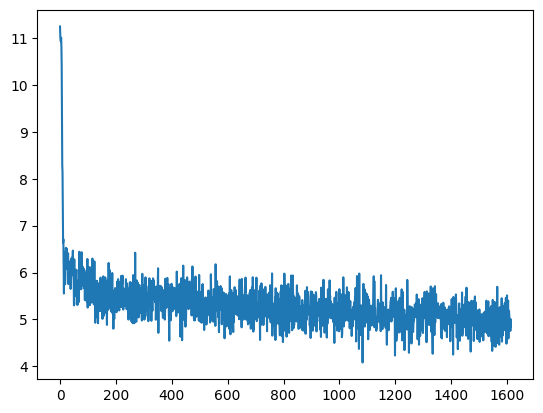

In [32]:
losses = []

input_length = target_length = seq_length

SOS = en_word2index["<SOS>"]
EOS = en_word2index["<EOS>"]

epochs = 1

for epoch in range(epochs):
    for idx, batch in enumerate(train_dl):

        # Creating initial hidden states for the encoder
        encoder_hidden = encoder.initHidden()

        # Sending to device
        encoder_hidden = encoder_hidden.to(device)

        # Assigning the input and sending to device
        input_tensor = batch[0].to(device)

        # Assigning the output and sending to device
        target_tensor = batch[1].to(device)


        # Clearing gradients
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()

        # Enabling gradient calculation
        with torch.set_grad_enabled(True):

            # Feeding batch into encoder
            encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

            # This is a placeholder tensor for decoder outputs. We send it to device as well
            dec_result = torch.zeros(target_length, batch_size, len(de_index2word)).to(device)

            # Creating a batch of SOS tokens which will all be fed to the decoder
            decoder_input = target_tensor[:, 0].unsqueeze(1).to(device)

            decoder_hidden = encoder_hidden.mean(dim=0).unsqueeze(0)
            # For each time-step in decoding:
            for i in range(1, target_length):

                # Feed input and previous hidden states
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Finding the best scoring word
                best = decoder_output.argmax(1)

                # Assigning next input as current best word
                decoder_input = best.unsqueeze(1)

                # Creating an entry in the placeholder output tensor
                dec_result[i] = decoder_output


            # Creating scores and targets for loss calculation
            scores = dec_result.transpose(1, 0)[1:].reshape(-1, dec_result.shape[2])
            targets = target_tensor[1:].reshape(-1)

            # Calculating loss
            loss = criterion(scores, targets)

            # Performing backprop and clipping excess gradients
            loss.backward()

            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1)

            enc_optimizer.step()
            dec_optimizer.step()

            # Keeping track of loss
            losses.append(loss.item())
            if idx % 100 == 0:
                print(idx, sum(losses)/len(losses))

plt.plot(losses)

In [33]:
from tqdm import tqdm
val_ids = [ i for i,_ in data["English-Hindi"]["Validation"].items()]

In [34]:
val_outs = []
for i in tqdm(range(len(test_ds))):
    # Fix 1: Initialize encoder hidden state with correct bidirectional dimensions
    encoder_hidden = torch.zeros(2, 1, hidden_size).to(device)  # (2 directions, batch_size=1, hidden_size)
    
    input_tensor = test_ds[i][0].unsqueeze(dim=0).to(device)
    result = []
    
    with torch.set_grad_enabled(False):
        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
        
        # Fix 2: Prepare decoder hidden state by averaging bidirectional layers
        decoder_hidden = encoder_hidden.mean(dim=0).unsqueeze(0)  # (1 layer, batch_size=1, hidden_size)
        
        decoder_input = torch.tensor([SOS]).unsqueeze(dim=1).to(device)  # (batch=1, seq_len=1)
        
        for di in range(1, target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            best = decoder_output.argmax(1)
            result.append(de_index2word[best.to('cpu').item()])
            
            if best.item() == EOS:
                break
                
            # Maintain consistent dimension for next input
            decoder_input = best.unsqueeze(1)  # (batch=1, seq_len=1)
    
    result = [i for i in result if i not in ['<EOS>', '<PAD>', '<SOS>']]
    val_outs.append(" ".join(result))

100%|██████████| 11543/11543 [01:39<00:00, 116.30it/s]


In [35]:
df0 = pd.DataFrame()
df0["ID"] = val_ids
df0["Translation"] = val_outs

In [36]:
df0.to_csv('/kaggle/working/answersH.csv', index = False)
x=pd.read_csv("/kaggle/working/answersH.csv")
x

,ID,Translation
0,505511,इस इस मेरे मेरी पर क्या है
1,505512,और और और और और और
2,505513,एक के के के के के के के के है के के के के है क...
3,505514,इस के के के के के लिए के के लिए लिए लिए लिए लिए
4,505515,इस के के के के एक के के के एक के के के है और औ...
...,...,...
11538,517049,इस के के के के के के के के के के के के के के क...
11539,517050,यह में में में में में में में में में है में ...
11540,517051,मुझे में में में में में में में में
11541,517052,इस में में के के के के के में पर


In [37]:
#Doing it for Bengali

In [38]:
with open('/kaggle/input/trainnn/train_data1.json', 'r') as file:
  # Replace this path with the dataset path in your local machine
    data = json.load(file)

In [39]:
# Process JSON data
source_sentences_train = []
target_sentences_train = []

source_sentences_val = []
target_sentences_val = []

id_train = []
id_val = []

In [40]:
for language_pair, language_data in data.items():
    if(language_pair == "English-Bengali"):
      print(f"Language Pair: {language_pair}")
      for data_type, data_entries in language_data.items():
          print(f"  Data Type: {data_type}")
          for entry_id, entry_data in data_entries.items():
              source = entry_data["source"]
              target = entry_data["target"]
              if (data_type == "Validation"):
                source_sentences_val.append(source)
                target_sentences_val.append(target)
                id_val.append(entry_id)
              else:
                source_sentences_train.append(source)
                target_sentences_train.append(target)
                id_train.append(entry_id)

Language Pair: English-Bengali
  Data Type: Train


In [41]:
with open('/kaggle/input/validation/val_data1.json', 'r') as file: # Replace this path with the dataset path in your local machine
    data = json.load(file)

In [42]:
for language_pair, language_data in data.items():
    if(language_pair == "English-Bengali"):
      print(f"Language Pair: {language_pair}")
      for data_type, data_entries in language_data.items():
          print(f"  Data Type: {data_type}")
          for entry_id, entry_data in data_entries.items():
              source = entry_data["source"]
              #target = entry_data["target"]
              if (data_type == "Validation"):
                source_sentences_val.append(source)
                #target_sentences_val.append(target)
                #id_val.append(entry_id)
              #else:
                #source_sentences_train.append(source)
                #target_sentences_train.append(target)
                #id_train.append(entry_id)

Language Pair: English-Bengali
  Data Type: Validation


In [43]:
print(len(source_sentences_train))
print(len(target_sentences_train))

print(len(source_sentences_val))
print(len(target_sentences_val))

68849
68849
9836
0


In [44]:
x={'English':source_sentences_train,'Bengali':target_sentences_train}
df=pd.DataFrame(x)
df

,English,Bengali
0,Do not forget to visit the point where the Nar...,এই জায়গাগুলো দেখতে ভুলো না যেখানে নর্মদা নদী ম...
1,It is evident that the biggest cause of povert...,এই কথা স্পষ্ট যে দরিদ্রতার বড় কারণ হল অশিক্ষা ।
2,The film was released theatrically on 12 April...,চলচ্চিত্রটি ২০১৩ সালের ১২ই এপ্রিল প্রেক্ষাগৃহে...
3,is wyatt's birthday party at ten p. m.,অনিমেষ এর জন্মদিনের পার্টি রাত দশটায়
4,"Apart from being used as an eatable, barley is...",খাদ্যদ্রব্য ছাড়াও যব আরো বিভিন্ন ক্ষেত্রে যেমন...
...,...,...
68844,But it is evident that there is change in both...,তাও এটা প্রত্যক্ষভাবে দেখা যায় যে প্রিন্ট মিড...
68845,Include a detailed listing of all of your prod...,ছবি সহ সম্পূর্ণ করা আপনার সমস্ত পণ্যের একটি বি...
68846,"Each subcategory counts as one page, pages in ...",প্রতিটি উপবিভাগ একটি পৃষ্ঠা হিসাবে গণনা করা হয...
68847,It is one of the country's oldest state-run pu...,এটি দেশের সবচেয়ে পুরনো রাষ্ট্র-চালিত সরকারী বা...


In [45]:
import nltk
from collections import Counter

target_sentences_train = [re.sub(r'[a-zA-Z]','',hi) for hi in target_sentences_train] #optional

In [46]:
english_tokens = preprocess(source_sentences_train)
english_test=preprocess(source_sentences_val)
bengali_tokens = preprocess(target_sentences_train)
bengali_test=preprocess(target_sentences_val)

en_train=english_tokens
en_test=english_test
be_train=bengali_tokens
be_test=bengali_test

In [47]:
en_index2word = ["<PAD>", "<SOS>", "<EOS>"]
be_index2word = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [en_train, en_test]:
    for sent in ds:
        for token in sent:
            if token not in en_index2word:
                en_index2word.append(token)

for ds in [be_train, be_test]:
    for sent in ds:
        for token in sent:
            if token not in be_index2word:
                be_index2word.append(token)

In [48]:
en_index2word

['<PAD>',
 '<SOS>',
 '<EOS>',
 'do',
 'not',
 'forget',
 'to',
 'visit',
 'the',
 'point',
 'where',
 'narmada',
 'flowing',
 'through',
 'marble',
 'rocks',
 'interchanges',
 'its',
 'calmness',
 'and',
 'serenity',
 'into',
 'insouciance',
 'it',
 'is',
 'evident',
 'that',
 'biggest',
 'cause',
 'of',
 'poverty',
 'illiteracy',
 'film',
 'was',
 'released',
 'theatrically',
 'on',
 'april',
 'wyatts',
 'birthday',
 'party',
 'at',
 'ten',
 'p',
 'm',
 'apart',
 'from',
 'being',
 'used',
 'as',
 'an',
 'eatable',
 'barley',
 'also',
 'in',
 'many',
 'other',
 'fields',
 'like',
 'industries',
 'agriculture',
 'emperor',
 'akbar',
 'got',
 'state',
 'museum',
 'constructed',
 'during',
 'his',
 'trip',
 'ajmer',
 'initiate',
 'music',
 'electronic',
 'playlist',
 'srinagar',
 'a',
 'distance',
 'kms',
 'jammu',
 'devotee',
 'chosen',
 'karaga',
 'or',
 'clay',
 'pot',
 'placed',
 'head',
 'city',
 'lined',
 'up',
 'with',
 'shops',
 'have',
 'everything',
 'you',
 'need',
 'stock',
 

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [50]:
en_word2index = {token: idx for idx, token in enumerate(en_index2word)}
be_word2index = {token: idx for idx, token in enumerate(be_index2word)}

len(en_word2index)

en_lengths = sum([len(sent) for sent in en_train])/len(en_train)
be_lengths = sum([len(sent) for sent in be_train])/len(be_train)

seq_length = 25

In [51]:
en_train_encoded = [encode_and_pad(en_word2index, sent, seq_length) for sent in en_train]
en_test_encoded = [encode_and_pad(en_word2index, sent, seq_length) for sent in en_test]
be_train_encoded = [encode_and_pad(be_word2index, sent, seq_length) for sent in be_train]
be_test_encoded = [encode_and_pad(be_word2index, sent, seq_length) for sent in be_test]

In [52]:
en_train_encoded[1]

[1,
 23,
 24,
 25,
 26,
 8,
 27,
 28,
 29,
 30,
 24,
 31,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [53]:
batch_size = 50

train_x = np.array(en_train_encoded)
train_y = np.array(be_train_encoded)
test_x = np.array(en_test_encoded)
test_y = np.array(be_test_encoded)

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x))


train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
#test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [54]:
train_x[1]
train_ds[1]

hidden_size = 128
seq_length = 25

In [55]:
encoder = EncoderRNN(len(en_index2word), hidden_size).to(device)
decoder = DecoderRNN(hidden_size, len(be_index2word)).to(device)

In [56]:
criterion = nn.CrossEntropyLoss()
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = 3e-3)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = 3e-3)

In [57]:
losses = []
input_length = target_length = seq_length

SOS = en_word2index["<SOS>"]
EOS = en_word2index["<EOS>"]

epochs = 1

for epoch in range(epochs):
    for idx, batch in enumerate(train_dl):

        # Creating initial hidden states for the encoder
        encoder_hidden = encoder.initHidden()

        # Sending to device
        encoder_hidden = encoder_hidden.to(device)

        # Assigning the input and sending to device
        input_tensor = batch[0].to(device)

        # Assigning the output and sending to device
        target_tensor = batch[1].to(device)


        # Clearing gradients
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()

        # Enabling gradient calculation
        with torch.set_grad_enabled(True):

            # Feeding batch into encoder
            encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

            # This is a placeholder tensor for decoder outputs. We send it to device as well
            dec_result = torch.zeros(target_length, batch_size, len(be_index2word)).to(device)

            # Creating a batch of SOS tokens which will all be fed to the decoder
            decoder_input = target_tensor[:, 0].unsqueeze(1).to(device)

            # Creating initial hidden states of the decoder by copying encoder hidden states
            decoder_hidden = encoder_hidden.mean(dim=0).unsqueeze(0)

            # For each time-step in decoding:
            for i in range(1, target_length):

                # Feed input and previous hidden states
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Finding the best scoring word
                best = decoder_output.argmax(1)

                # Assigning next input as current best word
                decoder_input = best.unsqueeze(1)

                # Creating an entry in the placeholder output tensor
                dec_result[i] = decoder_output


            # Creating scores and targets for loss calculation
            scores = dec_result.transpose(1, 0)[1:].reshape(-1, dec_result.shape[2])
            targets = target_tensor[1:].reshape(-1)

            # Calculating loss
            loss = criterion(scores, targets)

            # Performing backprop and clipping excess gradients
            loss.backward()

            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1)

            enc_optimizer.step()
            dec_optimizer.step()

            # Keeping track of loss
            losses.append(loss.item())
            if idx % 100 == 0:
                print(idx, sum(losses)/len(losses))

0 11.6265230178833
100 6.406448090430533
200 5.962523014391239
300 5.786182173858846
400 5.6719858283711195
500 5.609685461916134
600 5.5636561722207984
700 5.5178232526303015
800 5.486352819330833
900 5.453627705970959
1000 5.427461310223742
1100 5.4027382913878785
1200 5.380835756671915
1300 5.359717275984557


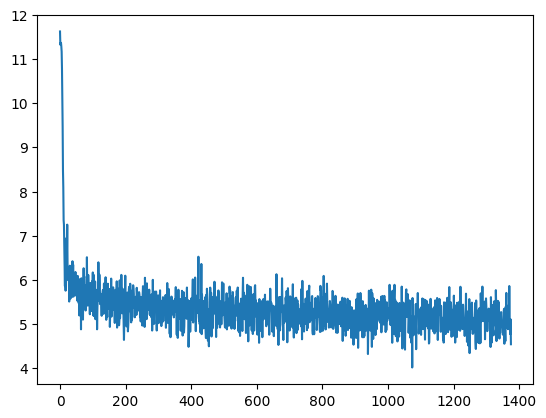

In [58]:
plt.plot(losses)

In [59]:
from tqdm import tqdm
val_ids = [ i for i,_ in data["English-Bengali"]["Validation"].items()]

val_outs = []
for i in tqdm(range(len(test_ds))):
    # Fix 1: Initialize encoder hidden state with correct bidirectional dimensions
    encoder_hidden = torch.zeros(2, 1, hidden_size).to(device)  # (2 directions, batch_size=1, hidden_size)
    
    input_tensor = test_ds[i][0].unsqueeze(dim=0).to(device)
    result = []
    
    with torch.set_grad_enabled(False):
        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
        decoder_hidden = encoder_hidden.mean(dim=0).unsqueeze(0)  # (1 layer, batch_size=1, hidden_size)
        decoder_input = torch.tensor([SOS]).unsqueeze(dim=1).to(device)  # (batch=1, seq_len=1)
        
        for di in range(1, target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            best = decoder_output.argmax(1)
            result.append(be_index2word[best.to('cpu').item()])
            
            if best.item() == EOS:
                break
                
            # Maintain consistent dimension for next input
            decoder_input = best.unsqueeze(1)  # (batch=1, seq_len=1)
    
    result = [i for i in result if i not in ['<EOS>', '<PAD>', '<SOS>']]
    val_outs.append(" ".join(result))

100%|██████████| 9836/9836 [01:21<00:00, 120.74it/s]


In [60]:
df0 = pd.DataFrame()
df0["ID"] = val_ids
df0["Translation"] = val_outs

In [61]:
df0.to_csv('answersB.csv', index = False)
x=pd.read_csv("/kaggle/working/answersB.csv")
x

,ID,Translation
0,147532,এই থেকে থেকে থেকে থেকে থেকে থেকে থেকে থেকে থেক...
1,147533,এখানে ও এবং এবং এবং এবং এবং এবং এবং এবং
2,147534,ভারতের ভারতের ভারতের এবং এবং এবং এবং এবং এবং এ...
3,147535,সালে সালে সালে সালে
4,147536,ভারতের হল একটি হল একটি একটি একটি একটি একটি একট...
...,...,...
9831,157363,এই এই এই এই এই একটি
9832,157364,এখানে হল হল আছে
9833,157365,এই হল হল
9834,157366,এই মধ্যে এবং এবং এবং ৷


In [62]:
df1 = pd.read_csv("/kaggle/working/answersB.csv") # Bengali
df2= pd.read_csv("/kaggle/working/answersH.csv")  # Hindi

In [63]:
df3 = pd.concat([df1, df2]) #Concat
df3.to_csv('answersBH.csv', index = False)
filtered_data = pd.read_csv("/kaggle/working/answersBH.csv")

answer = "/kaggle/working/answer.csv"
with open(answer, "w") as f:
  f.writelines("ID\tTranslation\n")
  for i in range(filtered_data.shape[0]):
    f.writelines(f'{filtered_data["ID"][i]}\t"{filtered_data["Translation"][i]}"\n')